# Membuat model R-CNN dari dataset

In [1]:
!pip install opencv-contrib-python --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 MB 9.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.5.4.60
    Uninstalling opencv-contrib-python-4.5.4.60:
      Successfully uninstalled opencv-contrib-python-4.5.4.60


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import cv2
import os

import tensorflow as tf
import tensorflow_hub

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img

In [3]:
train_dir = '../data/training_images_labeled/'

batch_size = 32
target_size = (224, 224)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=0.2,
                                                                brightness_range=[0.9,1.5],
                                                                horizontal_flip=True,
                                                                validation_split=0.2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        train_dir,
        class_mode='categorical',
        color_mode='rgb',
        target_size=target_size,
        batch_size=batch_size,
        subset='training')

val_generator = train_datagen.flow_from_directory(
        train_dir,
        class_mode='categorical',
        color_mode='rgb',
        target_size=target_size,
        batch_size=batch_size,
        subset='validation',
        shuffle=False)

Found 2613 images belonging to 2 classes.
Found 653 images belonging to 2 classes.


In [4]:
base_model = tf.keras.applications.MobileNetV3Small(include_top=False,input_shape=(target_size[0], target_size[0], 3))
base_model.trainable = False

2022-07-12 02:41:21.502457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 02:41:21.627983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 02:41:21.628823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 02:41:21.630402: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

6709248/6698480 [==============================] - 0s 0us/step


In [5]:
i = tf.keras.layers.Input([target_size[0], target_size[0], 3])
x = tf.cast(i, tf.float32)
x = tf.keras.applications.mobilenet_v3.preprocess_input(x)
x = base_model(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=i,outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3small (Functional (None, 1, 1, 1024)        1529968   
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                16400     
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34    

In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
# precision = tf.keras.metrics.Precision()
# recall = tf.keras.metrics.Recall()
# AUC = tf.keras.metrics.AUC()
model.compile(loss = 'categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4, restore_best_weights=True, verbose=0)
reduceLRonplateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=0)
checkpoint = tf.keras.callbacks.ModelCheckpoint('../esha/R_CNN',save_format='tf', monitor='val_accuracy', save_best_only=True,verbose=0)

tf.keras.backend.clear_session()

history = model.fit(train_generator,validation_data = val_generator,epochs=200, callbacks=[early_stopping,reduceLRonplateau,checkpoint],verbose=1)

2022-07-12 02:41:26.686256: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-07-12 02:41:31.420057: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


82/82 [==============================] - 64s 665ms/step - loss: 0.5174 - accuracy: 0.7310 - val_loss: 0.2907 - val_accuracy: 0.9204


2022-07-12 02:42:40.007003: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/200
82/82 [==============================] - 41s 499ms/step - loss: 0.2892 - accuracy: 0.8928 - val_loss: 0.2060 - val_accuracy: 0.9280
Epoch 3/200
82/82 [==============================] - 41s 498ms/step - loss: 0.2151 - accuracy: 0.9277 - val_loss: 0.1642 - val_accuracy: 0.9433
Epoch 4/200
82/82 [==============================] - 41s 500ms/step - loss: 0.1960 - accuracy: 0.9361 - val_loss: 0.1518 - val_accuracy: 0.9495
Epoch 5/200
82/82 [==============================] - 41s 502ms/step - loss: 0.1728 - accuracy: 0.9453 - val_loss: 0.1295 - val_accuracy: 0.9510
Epoch 6/200
82/82 [==============================] - 41s 501ms/step - loss: 0.1534 - accuracy: 0.9514 - val_loss: 0.1249 - val_accuracy: 0.9541
Epoch 7/200
82/82 [==============================] - 41s 495ms/step - loss: 0.1432 - accuracy: 0.9552 - val_loss: 0.1188 - val_accuracy: 0.9541
Epoch 8/200
82/82 [==============================] - 42s 508ms/step - loss: 0.1428 - accuracy: 0.9583 - val_loss: 0.1130 - val_accuracy:

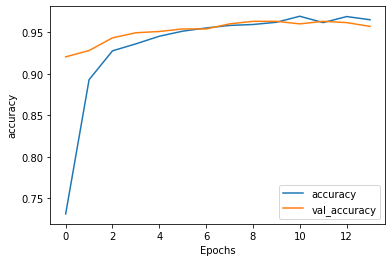

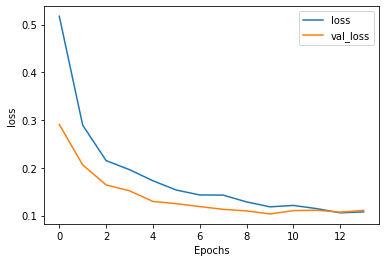

In [7]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [8]:
model_best = tf.keras.models.load_model('../esha/R_CNN')

../input/mltcoco/data/testing_images/vid_5_27480.jpg


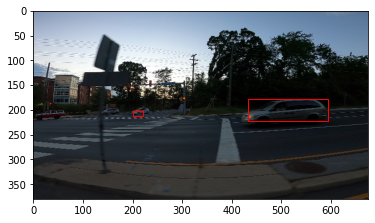

In [9]:
test_files = tf.io.gfile.glob('../data/testing_images/*.jpg')

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
max_proposed_boxes = 1000

i = '../input/mltcoco/data/testing_images/vid_5_27480.jpg'
filename = i.split('\\')[-1]
print(filename)

counter = 0
    
img = load_img(i)
normalized_img_array = img_to_array(img)

ss.setBaseImage(img_to_array(img))
ss.switchToSelectiveSearchFast()
rects = ss.process()

car_boxes = []
probas = []

for (x, y, w, h) in rects:

    if counter <= max_proposed_boxes:
        counter += 1
        filename_box = filename
        proposed_box = [x, y, x + w, y + h]

        image_array = normalized_img_array[proposed_box[1]:proposed_box[3],proposed_box[0]:proposed_box[2]]
        image_array = cv2.resize(image_array,target_size)

        predicted = model_best.predict(image_array.reshape(1,224,224,3), verbose=0)

        if np.argmax(predicted) == 1 and predicted[0][1] >= 0.9:
            car_boxes.append([y, x, y + h, x + w])
            probas.append(predicted[0][1])

img_w, img_h = 676, 380

im = Image.open(i)
fig, ax = plt.subplots()
ax.imshow(im)

try:
    selected_indices = tf.image.non_max_suppression(car_boxes, probas, 100, iou_threshold=0.0)
    selected_boxes = tf.gather(car_boxes, selected_indices)
    for i in selected_boxes:
        ymin, xmin, ymax, xmax = i[0], i[1], i[2], i[3]
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
except:
    pass
plt.show()